In [ ]:
# Install packages
# %pip install networkx
# %pip install numpy
# %pip install tqdm
# %pip install matplotlib

In [1]:
# The starter code is short and simple, take a look!
from starter import *
from physics_misc import *
import itertools
import random

<IPython.core.display.Javascript object>

# Phase 1 - Create Inputs

In [ ]:
# Add edges with G.add_edge(u, v, weight=w)
# Idea: consider making the inputs with a solution in mind, 
# such that you know the solution when the outputs are released

def np_int32_to_int(G: nx.Graph):
    for u, v, d in G.edges(data=True):
        d['weight'] = int(d['weight'])

def random_generate(G: nx.Graph):
    edges = []
    for u in range(G.number_of_nodes()):
        for v in range(u + 1, G.number_of_nodes()):
            edges.append((u, v))
    random.shuffle(edges)
    for u, v in edges[:min(MAX_EDGES, len(edges))]:
        if u == v:
            continue
        G.add_edge(u, v, weight=random.randint(1, MAX_WEIGHT))
    while sum(d for u, v, d in G.edges(data='weight')) < MIN_NET_WEIGHT:
        u, v = random.randint(0, G.number_of_nodes() - 1), random.randint(0, G.number_of_nodes() - 1)
        if u == v:
            continue
        G.add_edge(u, v, weight=random.randint(1, MAX_WEIGHT))
    np_int32_to_int(G)

def lopsided_generate(G: nx.Graph):
    # few nodes have edges to every other node
    edges = []
    for u in range(G.number_of_nodes()):
        for v in range(u + 1, G.number_of_nodes()):
            edges.append((u, v))
    edges = edges[:min(MAX_EDGES, len(edges))]
    for u, v in edges:
        G.add_edge(u, v, weight=random.randint(MAX_WEIGHT, MAX_WEIGHT))
    np_int32_to_int(G)
    
def scatter_close_generate(G: nx.Graph):
    node_pos = np.random.randint(0, 1000, (G.number_of_nodes(), 5))
    print(node_pos)
    max_edges_per_node = MAX_EDGES // G.number_of_nodes() - 3
    for u in range(G.number_of_nodes()):
        dist = [(v, np.linalg.norm(node_pos[u] - node_pos[v])) for v in range(G.number_of_nodes()) if u != v]
        dist.sort(key=lambda x: x[1])
        for v, w in dist[:5]:
            G.add_edge(u, v, weight=max(1, min(MAX_WEIGHT, int(round(w)))))
    while not nx.is_connected(G):
        dist = [(u, v, np.linalg.norm(node_pos[u] - node_pos[v])) for u, v in itertools.combinations(range(G.number_of_nodes()), 2) if u != v and not G.has_edge(u, v)]
        dist.sort(key=lambda x: x[2])
        for u, v, w in dist:
            G.add_edge(u, v, weight=max(1, min(MAX_WEIGHT, int(round(w)))))
            break
    print(G.number_of_edges())
    print(sum(d for u, v, d in G.edges(data='weight')))
    np_int32_to_int(G)

def triangle_circle_generate(G: nx.Graph):
    max_edges_per_node = MAX_EDGES // G.number_of_nodes()
    edges = []
    for u in range(G.number_of_nodes()):
        for v in range(u + 1, u + max_edges_per_node + 1):
            edges.append((u, v % G.number_of_nodes()))
    for u, v in edges:
        G.add_edge(u, v, weight=random.randint(1, max(u, v)))
    np_int32_to_int(G)

def random_prior_generate(G: nx.Graph):
    max_edges_per_node = MAX_EDGES // G.number_of_nodes()
    for u in range(max_edges_per_node, G.number_of_nodes()):
        vs = random.sample(range(u), max_edges_per_node)
        for v in vs:
            G.add_edge(u, v, weight=random.randint(max(min(u, v), 1), max(u, v)))
    for u, v in itertools.combinations(range(max_edges_per_node), 2):
        if u == v:
            continue
        G.add_edge(u, v, weight=random.randint(max(min(u, v), 1), max(u, v)))

def multiply_generate(G: nx.Graph):
    for u in range(G.number_of_nodes()):
        for v in range(u + 1, G.number_of_nodes()):
            if (u + 1) * (v + 1) % MAX_WEIGHT > 0:
                G.add_edge(u, v, weight=(u + 1) * (v + 1) % MAX_WEIGHT)

def small(G: nx.Graph):
    multiply_generate(G)

def medium(G: nx.Graph):
    random_prior_generate(G)

def large(G: nx.Graph):
    triangle_circle_generate(G)

def hw11_6c(dim = 4):
    G = nx.empty_graph(dim * dim)
    for i in range(dim):
        for j in range(dim):
            if i > 0:
                G.add_edge(i * dim + j, (i - 1) * dim + j, weight=1)
            if j > 0:
                G.add_edge(i * dim + j, i * dim + j - 1, weight=1)
    np_int32_to_int(G)
    return G

In [ ]:
G = nx.empty_graph(N_SMALL)
small(G)
write_input(G, '../tests/small/multiply/')

# G = nx.empty_graph(N_MEDIUM)
# medium(G)
# write_input(G, '../tests/medium/prior/')

# G = nx.empty_graph(N_LARGE)
# large(G)
# write_input(G, '../tests/large/circle/')

# Phase 2 - Implement your Solver

In [ ]:
IN_FILE = '../tests/large/lopsided_1/'

def copy_teams(G: nx.Graph, G_copy: nx.Graph):
    for v in G:
        G.nodes[v]['team'] = G_copy.nodes[v]['team']

def random_solve(G: nx.Graph, team_size = 10):
    for v in G:
        G.nodes[v]['team'] = random.randint(1, random.randint(1, team_size))

def random_sample_solve(G: nx.Graph):
    G_best, best_score = G.copy(), float('inf')
    for _ in range(1000):
        random_solve(G)
        new_score = score(G)
        if new_score < best_score:
            G_best, best_score = G.copy(), new_score
    copy_teams(G, G_best)

def solve(G: nx.Graph):
    # physics_solve(G, 11, dim=6, vel_decay=0.999, total_steps=1000)
    random_sample_solve(G)
    
def score_to_str(score: float):
    return str(round(score))

def write_output_general(G: nx.Graph, path: str, overwrite=False, copy=True, suffix=''):
    if suffix != '':
        suffix = '_' + suffix
    write_output(G, path + '{}{}.out'.format(score_to_str(score(G)), suffix), overwrite=overwrite, copy=copy)

def visualize_general(G: nx.Graph, path: str, overwrite=False, copy=True, suffix=''):
    if suffix != '':
        suffix = '_' + suffix
    visualize(G, path + '{}{}.png'.format(score_to_str(score(G)), suffix))

G = read_input(IN_FILE + 'graph.in')
solve(G)
validate_output(G)
run_type = 'rand'
write_output_general(G, IN_FILE, overwrite=True, suffix=run_type)
visualize_general(G, IN_FILE, suffix=run_type)
score(G)

In [ ]:
run_all(solve, '../tests/', '../submission/', overwrite=True)
tar('../phase_2/', path='../submission.tar')

# Custom Visualizer

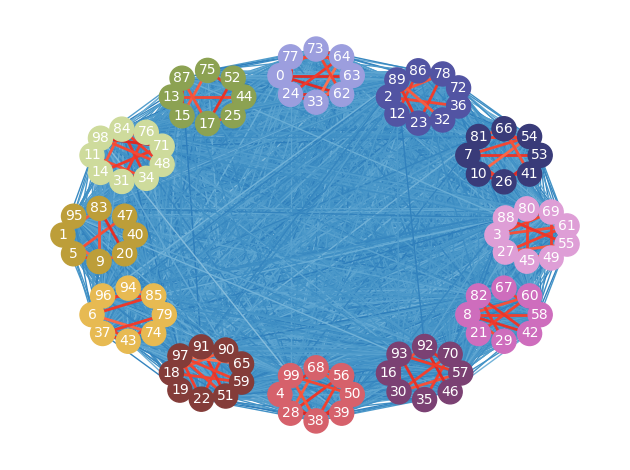

164162.01581064696

In [3]:
FILE = '164162_sim_anneal'
TEST_FOLDER = '../tests/small/small1/'
IN_FILE = TEST_FOLDER + 'graph.in'
OUT_FILE = TEST_FOLDER + FILE + '.out'
G = read_input(IN_FILE)
read_output(G, OUT_FILE)
validate_output(G)
visualize(G, path=TEST_FOLDER + FILE + '.png')
score(G)